## Overview

In this notebook, we will practice with image classification using Convoluational Neural Network (CNN). The dataset we will use is `MARCO`(details see https://marco.ccr.buffalo.edu/about). This is a dataset of over 400000 protein crystal images, with four categories: Clear, Crystals, Other, Precipitate. In this session we will use only a small subset of MARCO data, to train a convolutional neural network that can classify the protein crystal images into Clear, Crystals, Other, Precipitate.

## Read in Image Data

In [6]:
from skimage.io import imread
from skimage.io import imsave
import matplotlib.pyplot as plt

Please download the marco.tar.gz file from Canvas and upload it to your current directory.

In [ ]:
#unzip the file
! tar -xf ./marcodata.tar.gz

Read in and diaplay the image:

In [8]:
sample = imread('./marcodata/Crystals/4885.jpeg')
sample.shape

(300, 300, 3)

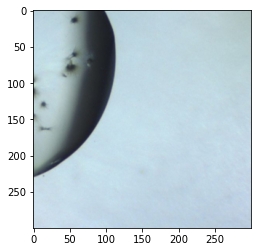

In [9]:
plt.imshow(sample)

## Prepare Train, Validation and Test Dataset

In [10]:
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [11]:
#Collect the path of all training images in a list
paths = glob.glob('./marcodata/Clear/*.jpeg')+glob.glob('./marcodata/Crystals/*.jpeg')+glob.glob('./marcodata/Precipitate/*.jpeg')+glob.glob('./marcodata/Other/*.jpeg')

We convert the 4 categories into integers: <br>
0: clear <br>
1: crystal <br>
2: precipitate <br>
3: Other <br>

In [12]:
#count the number of samples in each folder
num_clear = len(glob.glob('./marcodata/Clear/*.jpeg'))
num_crystal = len(glob.glob('./marcodata/Crystals/*.jpeg'))
num_preci = len(glob.glob('./marcodata/Precipitate/*.jpeg'))
num_other = len(glob.glob('./marcodata/Other/*.jpeg'))

# Convert the labels into integers
#0: clear
#1: crystal
#2: precipitate
#3: Other
labels = [str(0)]*num_clear+[str(1)]*num_crystal+[str(2)]*num_preci+[str(3)]*num_other

In [13]:
# split images into train data and test data
img_train, img_test, label_train, label_test = train_test_split(paths,labels,test_size = 0.3)

# split images into train data and validation data
img_train, img_val, label_train, label_val = train_test_split(img_train,label_train,test_size = 0.2)

In [14]:
# pack the image path and labels in dataframe
df_train = pd.DataFrame(data=list(zip(img_train,label_train)),columns=['path','label'])
df_val = pd.DataFrame(data=list(zip(img_val,label_val)),columns=['path','label'])
df_test = pd.DataFrame(data=list(zip(img_test,label_test)),columns=['path','label'])

In [15]:
df_train.head()

,path,label
0,./marcodata/Other/385805.jpeg,3
1,./marcodata/Precipitate/5729.jpeg,2
2,./marcodata/Crystals/186112.jpeg,1
3,./marcodata/Crystals/471302.jpeg,1
4,./marcodata/Clear/278115.jpeg,0


In [16]:
df_test.head()

,path,label
0,./marcodata/Crystals/486033.jpeg,1
1,./marcodata/Crystals/224874.jpeg,1
2,./marcodata/Precipitate/136278.jpeg,2
3,./marcodata/Crystals/245126.jpeg,1
4,./marcodata/Other/351035.jpeg,3


In [39]:
# save the df_test into a csv file, you can load this when you evalute the model
df_test.to_csv('./testdata.csv')

## Construct Convolutional Neural Network

Here we construct a convolutional neural network by adding a `GlobalAveragePooling2D` layer and a few `Dense`,`Dropout` layers on top of a base model called `DenseNet121`. DenseNet121 is a Dense Convolutional Network with pretrained weights (More details can be found from the paper: https://arxiv.org/abs/1608.06993 )

In [18]:
# parameters 
nclasses = 4
nchannels = 3 #RGB
imagesize=(300,300)
batchsize=20
epochs=5  #how many epochs you want your CNN to be trained
model_dir = './model/'
model_path = model_dir+'MARCO.{epoch:02d}-{val_accuracy:.4f}.hdf5' # Path at which to save the model file

#Load the densenet as a basemodel
basemodel = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(imagesize[0],imagesize[1],nchannels))
basemodel.trainable = True

#Build CNN
model = tf.keras.Sequential()
model.add(basemodel)
model.add(tf.keras.layers.GlobalAveragePooling2D())  #Join the global average pooling layer
model.add(tf.keras.layers.Dense(512,activation='relu'))  #Add fully connected layer
model.add(tf.keras.layers.Dropout(rate=0.25))  #Add Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(128,activation='relu'))  #Add fully connected layer
model.add(tf.keras.layers.Dropout(rate=0.25))  #Add Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dense(nclasses,activation='softmax'))  #Add output layer
model.summary()   #Print each layer parameter information 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 9, 9, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5

## Image Augmentation

The `ImageDataGenerator` from tensorflow is used to load the image data from the file path we specified, and apply the image augmentation. By image augmentation, we can artifically creates new images through applying operations such as rotation, shift, flip to the original images. 


Here we create two instances of the ImageDataGenerator to generate training data and validation data respectively. In training data generator, we use a set of parameters to define the image augmentation operations. 

In [19]:
# ImageDataGenerator for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=15,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=[0.9, 1.2],
                horizontal_flip=True,
                vertical_flip=True,
                fill_mode='reflect',
                rescale=1./255
                )

# ImageDataGenerator for validation data
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )


The `flow_from_dataframe` method of the ImageDataGenerator will load the images with their labels given in the dataframes we created above. 

In [20]:
train_generator = train_datagen.flow_from_dataframe(
                df_train, #this is the training data
                x_col = 'path',  
                y_col ='label',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = True,
                class_mode='sparse')

validation_generator = validation_datagen.flow_from_dataframe(
                df_val,  #This is the validation data
                x_col = 'path',  
                y_col ='label',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False,
                class_mode='sparse')

Found 11200 validated image filenames belonging to 4 classes.
Found 2800 validated image filenames belonging to 4 classes.


(Important) make sure both the training data and validation data contains all 4 categories of the images.

## Train the model

In [14]:
#Compile model
initial_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Cross entropy loss function
              metrics=["accuracy"]) #Evaluation function

#Callback function: Save the optimal model
checkpoint = ModelCheckpoint(
                                filepath=model_path, # Path at which to save the model file.
                                monitor='val_accuracy', #Need to monitor the value
                                save_weights_only=True, #If set to True, only the model weight will be saved, otherwise the entire model (including model structure, configuration information, etc.) will be saved
                                save_best_only=True, #When set to True, the current model will only be saved when the monitoring value is improved
                                mode='auto', #When the monitoring value is val_acc, the mode should be max. When the monitoring value is val_loss, the mode should be min. In auto mode, the evaluation criterion is automatically inferred from the name of the monitored value
                                verbose=1 #If True, output a message for each update, default value: False
                            )

In [15]:
#fit the model
history = model.fit(x=train_generator,   #Enter training set
                    steps_per_epoch=train_generator.n // batchsize, #The number of training steps included in an epoch
                    epochs=epochs, #Training model iterations
                    validation_data=validation_generator,  #Enter validation set
                    validation_steps=validation_generator.n // batchsize, #The number of validation steps included in an epoch
                    callbacks=[checkpoint])

model.save(model_dir + 'MARCO.h5')

Epoch 1/5
14/14 [==============================] - 35s 2s/step - loss: 1.5823 - accuracy: 0.3455 - val_loss: 1.3303 - val_accuracy: 0.2500
Epoch 2/5
14/14 [==============================] - 22s 2s/step - loss: 1.1928 - accuracy: 0.4930 - val_loss: 1.4359 - val_accuracy: 0.4167
Epoch 3/5
14/14 [==============================] - 22s 2s/step - loss: 1.6471 - accuracy: 0.4117 - val_loss: 1.3890 - val_accuracy: 0.2500
Epoch 4/5
14/14 [==============================] - 22s 2s/step - loss: 1.0977 - accuracy: 0.3987 - val_loss: 1.2802 - val_accuracy: 0.3333
Epoch 5/5
14/14 [==============================] - 22s 2s/step - loss: 0.8261 - accuracy: 0.7668 - val_loss: 1.0041 - val_accuracy: 0.4167


In each epoch of the training process, the ImageDataGenerator we created (train_generator) will load the images and perform the augmentation. The model will then be updated (i.e. fitted) based on the augmented images.


## Model Evaluation

In this section, we will evaluate the model's performance on the test dataset we prepared earlier. 

In [34]:
# load the trained model
# !!!!!! please make sure modify it to the name of your model and model weights !!!!!
model = keras.models.load_model('./models/<yourmodel>.h5',compile=False)
model.load_weights('./models/<yourweights>.hdf5')

#Compile model
initial_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Cross entropy loss function
              metrics=["accuracy"]) #Evaluation function

The test images can still be loaded using the ImageDataGenerator. 

In [37]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255
                )

test_generator = test_datagen.flow_from_dataframe(
                df_test,  #This is the test dataset
                x_col = 'path',  
                y_col ='label',
                target_size=imagesize,  
                batch_size=batchsize,
                shuffle = False,
                class_mode='sparse')

Found 6000 validated image filenames belonging to 4 classes.


Evaluate the model, get the accuracy:

In [ ]:
model.evaluate(test_generator)